In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Load data
df = pd.read_csv('news_headlines.csv')

        headline  sentiment
0          False      False
1          False      False
2          False      False
3          False      False
4          False      False
...          ...        ...
200495     False      False
200496     False      False
200497     False      False
200498     False      False
200499     False      False

[200500 rows x 2 columns]


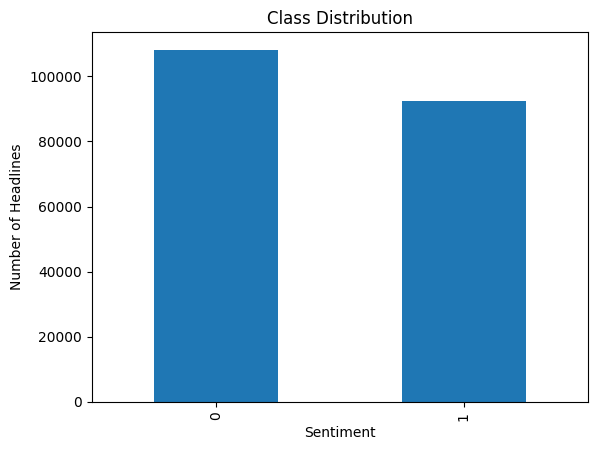

In [2]:
# Check for missing data
missing_data = df.isnull()
print(missing_data)

# Check for data imbalance
class_counts = df['sentiment'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Headlines')
plt.show()

# Preprocess data
stop_words = stopwords.words('english')
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = tokenizer.tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

df['text'] = df['headline'].apply(preprocess_text)

In [3]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.3, random_state=42)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = max([len(x) for x in X_train_seq])
X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [4]:
# Define deep learning model
model = Sequential()
model.add(Embedding(5000, 64, input_length=max_length))
model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu',kernel_initializer='glorot_uniform',bias_initializer='zeros')))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [5]:
# Train deep learning model
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), callbacks=[early_stopping])

# Evaluate deep learning model
dl_y_train_pred = np.argmax(model.predict(X_train_pad), axis=-1)
dl_y_pred = np.argmax(model.predict(X_test_pad), axis=-1)

dl_train_acc = accuracy_score(y_train, dl_y_train_pred)
dl_train_prc = precision_score(y_train, dl_y_train_pred)
dl_train_rec = recall_score(y_train, dl_y_train_pred)
dl_train_f1s = f1_score(y_train, dl_y_train_pred)

dl_acc = accuracy_score(y_test, dl_y_pred)
dl_prc = precision_score(y_test, dl_y_pred)
dl_rec = recall_score(y_test, dl_y_pred)
dl_f1s = f1_score(y_test, dl_y_pred)

dl_conf_mat = confusion_matrix(y_test, dl_y_pred)

Epoch 1/10
4386/4386 [==============================] - 316s 71ms/step - loss: 35.1113 - accuracy: 0.7374 - val_loss: 49.4897 - val_accuracy: 0.7726
Epoch 2/10
4386/4386 [==============================] - 319s 73ms/step - loss: 0.4619 - accuracy: 0.7843 - val_loss: 19.0708 - val_accuracy: 0.7787
Epoch 3/10
4386/4386 [==============================] - 317s 72ms/step - loss: 0.4334 - accuracy: 0.7974 - val_loss: 0.4620 - val_accuracy: 0.7810
Epoch 4/10
4386/4386 [==============================] - 323s 74ms/step - loss: 0.4096 - accuracy: 0.8107 - val_loss: 0.4592 - val_accuracy: 0.7822
Epoch 5/10
4386/4386 [==============================] - 328s 75ms/step - loss: 0.3861 - accuracy: 0.8219 - val_loss: 0.4713 - val_accuracy: 0.7761
Epoch 6/10
1880/1880 [==============================] - 33s 18ms/step


In [6]:
#Print evaluation metrics for deep learning model
print('Deep Learning Model (Training Set):')
print('Accuracy:', dl_train_acc)
print('Precision:', dl_train_prc)
print('Recall:', dl_train_rec)
print('F1 score:', dl_train_f1s)
print('Confusion matrix:\n', dl_conf_mat)

print('Deep Learning Model (Test Set):')
print('Accuracy:', dl_acc)
print('Precision:', dl_prc)
print('Recall:', dl_rec)
print('F1 score:', dl_f1s)
print('Confusion matrix:\n', dl_conf_mat)

Deep Learning Model (Training Set):
Accuracy: 0.854214463840399
Precision: 0.8225731130698734
Recall: 0.8716077254944409
F1 score: 0.8463808158086386
Confusion matrix:
 [[24921  7516]
 [ 5712 22001]]
Deep Learning Model (Test Set):
Accuracy: 0.7800831255195345
Precision: 0.7453670765999255
Recall: 0.7938873452892145
F1 score: 0.768862484710816
Confusion matrix:
 [[24921  7516]
 [ 5712 22001]]


In [7]:
#Define XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.3, random_state=42)

# Define vectorizers
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# Fit vectorizers to training data and transform test data
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

In [8]:
#Define hyperparameters for XGBoost classifier
xgb_hyperparameters = {'learning_rate': [0.1, 0.2], 'max_depth': [5, 10], 'n_estimators': [50, 100]}

In [9]:
#Perform hyperparameter tuning using GridSearchCV
xgb_grid = GridSearchCV(xgb_classifier, xgb_hyperparameters, cv=5)
xgb_grid.fit(X_train_tfidf, y_train)

#Print best hyperparameters
print('XGBoost best hyperparameters:', xgb_grid.best_params_)

XGBoost best hyperparameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}


In [10]:
#Train classifier on training data using the best hyperparameters
xgb_classifier = xgb.XGBClassifier(n_estimators=xgb_grid.best_params_['n_estimators'], max_depth=xgb_grid.best_params_['max_depth'], learning_rate=xgb_grid.best_params_['learning_rate'], random_state=42)
xgb_classifier.fit(X_train_tfidf, y_train)

#Predict on training data using XGBoost classifier
xgb_y_train_pred = xgb_classifier.predict(X_train_tfidf)

In [11]:
#Evaluate XGBoost classifier on training data
xgb_train_conf_mat = confusion_matrix(y_train, xgb_y_train_pred)

xgb_train_acc = accuracy_score(y_train, xgb_y_train_pred)
xgb_train_prc = precision_score(y_train, xgb_y_train_pred, average='weighted')
xgb_train_rec = recall_score(y_train, xgb_y_train_pred, average='weighted')
xgb_train_f1s = f1_score(y_train, xgb_y_train_pred, average='weighted')

print('XGBoost Classifier (Training Set):')
print('Accuracy:', xgb_train_acc)
print('Precision:', xgb_train_prc)
print('Recall:', xgb_train_rec)
print('F1 score:', xgb_train_f1s)
print('Confusion matrix:\n', xgb_train_conf_mat)

XGBoost Classifier (Training Set):
Accuracy: 0.7716209476309227
Precision: 0.7730122602694953
Recall: 0.7716209476309227
F1 score: 0.7719123708691044
Confusion matrix:
 [[58048 17633]
 [14420 50249]]


In [13]:
#Predict on test data using XGBoost classifier
xgb_y_pred = xgb_classifier.predict(X_test_tfidf)

#Evaluate XGBoost classifier on test data
xgb_conf_mat = confusion_matrix(y_test, xgb_y_pred)

xgb_acc = accuracy_score(y_test, xgb_y_pred)
xgb_prc = precision_score(y_test, xgb_y_pred, average='weighted')
xgb_rec = recall_score(y_test, xgb_y_pred, average='weighted')
xgb_f1s = f1_score(y_test, xgb_y_pred, average='weighted')

print('XGBoost Classifier (Test Set):')
print('Accuracy:', xgb_acc)
print('Precision:', xgb_prc)
print('Recall:', xgb_rec)
print('F1 Score:', xgb_f1s)
print('Confusion matrix:\n', xgb_conf_mat)

XGBoost Classifier (Test Set):
Accuracy: 0.7310556940980881
Precision: 0.7322432487735948
Recall: 0.7310556940980881
F1 Score: 0.7313678140702587
Confusion matrix:
 [[23758  8679]
 [ 7498 20215]]


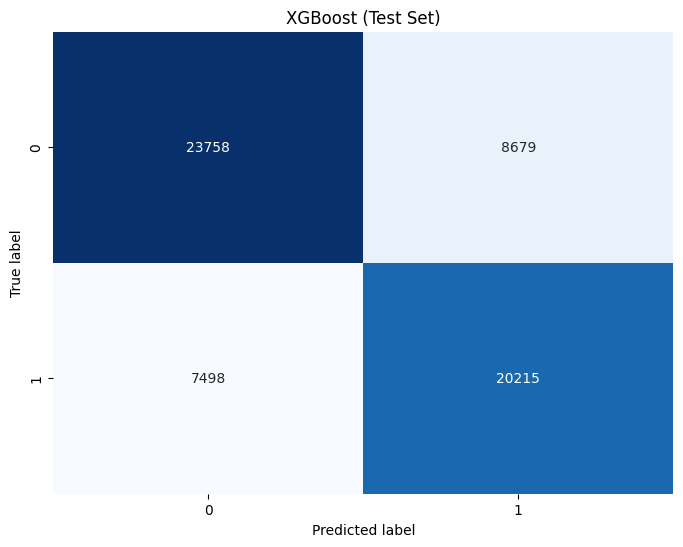

In [14]:
#Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(xgb_conf_mat, annot=True, cmap='Blues', fmt='g', ax=ax, cbar=False)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('XGBoost (Test Set)')
plt.show()

In [17]:
#Use traditional ML agorithms
# Define vectorizers
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# Fit vectorizers to training data and transform test data
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define classifiers
nb_classifier = MultinomialNB()
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)

In [18]:
# Define hyperparameters
nb_hyperparameters = {'alpha': [0.5, 1.0]}
lr_hyperparameters = {'C': [5.0, 10.0]}
rf_hyperparameters = {'n_estimators': [10, 100], 'max_depth': [5, 20]}

# Perform hyperparameter tuning
nb_grid = GridSearchCV(nb_classifier, nb_hyperparameters, cv=5)
nb_grid.fit(X_train_counts, y_train)

lr_grid = GridSearchCV(lr_classifier, lr_hyperparameters, cv=5)
lr_grid.fit(X_train_tfidf, y_train)

rf_grid = GridSearchCV(rf_classifier, rf_hyperparameters, cv=5)
rf_grid.fit(X_train_tfidf, y_train)

# Print best hyperparameters
print('Multinomial Naive Bayes best hyperparameters:', nb_grid.best_params_)
print('Logistic Regression best hyperparameters:', lr_grid.best_params_)
print('Random Forest best hyperparameters:', rf_grid.best_params_)

Multinomial Naive Bayes best hyperparameters: {'alpha': 1.0}
Logistic Regression best hyperparameters: {'C': 5.0}
Random Forest best hyperparameters: {'max_depth': 20, 'n_estimators': 10}


In [19]:
#Train classifiers on training data with best hyperparameters
nb_classifier = MultinomialNB(alpha=nb_grid.best_params_['alpha'])
lr_classifier = LogisticRegression(C=lr_grid.best_params_['C'], max_iter=1000, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=rf_grid.best_params_['n_estimators'], max_depth=rf_grid.best_params_['max_depth'], random_state=42)

nb_classifier.fit(X_train_counts, y_train)
lr_classifier.fit(X_train_tfidf, y_train)
rf_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=20, n_estimators=10, random_state=42)

In [20]:
#Predict on training data
nb_y_train_pred = nb_classifier.predict(X_train_counts)
lr_y_train_pred = lr_classifier.predict(X_train_tfidf)
rf_y_train_pred = rf_classifier.predict(X_train_tfidf)

#Evaluate classifiers on training data
nb_train_conf_mat = confusion_matrix(y_train, nb_y_train_pred)
lr_train_conf_mat = confusion_matrix(y_train, lr_y_train_pred)
rf_train_conf_mat = confusion_matrix(y_train, rf_y_train_pred)

nb_train_acc = accuracy_score(y_train, nb_y_train_pred)
nb_train_prc = precision_score(y_train, nb_y_train_pred, average='weighted')
nb_train_rec = recall_score(y_train, nb_y_train_pred, average='weighted')
nb_train_f1s = f1_score(y_train, nb_y_train_pred, average='weighted')

lr_train_acc = accuracy_score(y_train, lr_y_train_pred)
lr_train_prc = precision_score(y_train, lr_y_train_pred, average='weighted')
lr_train_rec = recall_score(y_train, lr_y_train_pred, average='weighted')
lr_train_f1s = f1_score(y_train, nb_y_train_pred, average='weighted')

In [21]:
#Evaluate decision tree classifier on training data
rf_train_acc = accuracy_score(y_train, rf_y_train_pred)
rf_train_prc = precision_score(y_train, rf_y_train_pred, average='weighted')
rf_train_rec = recall_score(y_train, rf_y_train_pred, average='weighted')
rf_train_f1s = f1_score(y_train, rf_y_train_pred, average='weighted')

In [22]:
print('Multinomial Naive Bayes (Training Set):')
print('Accuracy:', nb_train_acc)
print('Precision:', nb_train_prc)
print('Recall:', nb_train_rec)
print('F1 score:', nb_train_f1s)
print('Confusion matrix:\n', nb_train_conf_mat)

print('Logistic Regression (Training Set):')
print('Accuracy:', lr_train_acc)
print('Precision:', lr_train_prc)
print('Recall:', lr_train_rec)
print('F1 score:', lr_train_f1s)
print('Confusion matrix:\n', lr_train_conf_mat)

print('Random Forest (Training Set):')
print('Accuracy:', rf_train_acc)
print('Precision:', rf_train_prc)
print('Recall:', rf_train_rec)
print('F1 score:', rf_train_f1s)
print('Confusion matrix:\n', rf_train_conf_mat)

Multinomial Naive Bayes (Training Set):
Accuracy: 0.7891556822230139
Precision: 0.7892407721359687
Recall: 0.7891556822230139
F1 score: 0.7884334491505705
Confusion matrix:
 [[63056 12625]
 [16967 47702]]
Logistic Regression (Training Set):
Accuracy: 0.8469112931955824
Precision: 0.8468230496808201
Recall: 0.8469112931955824
F1 score: 0.7884334491505705
Confusion matrix:
 [[65304 10377]
 [11109 53560]]
Random Forest (Training Set):
Accuracy: 0.6075810473815462
Precision: 0.7040610805470876
Recall: 0.6075810473815462
F1 score: 0.5297355329278273
Confusion matrix:
 [[73578  2103]
 [52973 11696]]


In [23]:
#Predict on test data
nb_y_pred = nb_classifier.predict(X_test_counts)
lr_y_pred = lr_classifier.predict(X_test_tfidf)
rf_y_pred = rf_classifier.predict(X_test_tfidf)

#Evaluate classifiers on test data
nb_conf_mat = confusion_matrix(y_test, nb_y_pred)
lr_conf_mat = confusion_matrix(y_test, lr_y_pred)
rf_conf_mat = confusion_matrix(y_test, rf_y_pred)

nb_acc = accuracy_score(y_test, nb_y_pred)
nb_prc = precision_score(y_test, nb_y_pred, average='weighted')
nb_rec = recall_score(y_test, nb_y_pred, average='weighted')
nb_f1s = f1_score(y_test, nb_y_pred, average='weighted')

lr_acc = accuracy_score(y_test, lr_y_pred)
lr_prc = precision_score(y_test, lr_y_pred, average='weighted')
lr_rec = recall_score(y_test, lr_y_pred, average='weighted')
lr_f1s = f1_score(y_test, lr_y_pred, average='weighted')

rf_acc = accuracy_score(y_test, rf_y_pred)
rf_prc = precision_score(y_test, rf_y_pred, average='weighted')
rf_rec = recall_score(y_test, rf_y_pred, average='weighted')
rf_f1s = f1_score(y_test, rf_y_pred, average='weighted')

In [24]:
print('Multinomial Naive Bayes (Test Set):')
print('Accuracy:', nb_acc)
print('Precision:', nb_prc)
print('Recall:', nb_rec)
print('F1 score:', nb_f1s)
print('Confusion matrix:\n', nb_conf_mat)

print('Logistic Regression (Test Set):')
print('Accuracy:', lr_acc)
print('Precision:', lr_prc)
print('Recall:', lr_rec)
print('F1 score:', lr_f1s)
print('Confusion matrix:\n', lr_conf_mat)

print('Random Forest (Test Set):')
print('Accuracy:', rf_acc)
print('Precision:', rf_prc)
print('Recall:', rf_rec)
print('F1 score:', rf_f1s)
print('Confusion matrix:\n', rf_conf_mat)

Multinomial Naive Bayes (Test Set):
Accuracy: 0.7535660847880299
Precision: 0.7535075715041225
Recall: 0.7535660847880299
F1 score: 0.752512699665194
Confusion matrix:
 [[26127  6310]
 [ 8513 19200]]
Logistic Regression (Test Set):
Accuracy: 0.785453034081463
Precision: 0.7853111345720066
Recall: 0.785453034081463
F1 score: 0.785362074871664
Confusion matrix:
 [[26136  6301]
 [ 6604 21109]]
Random Forest (Test Set):
Accuracy: 0.5944970906068163
Precision: 0.6736927863143459
Recall: 0.5944970906068163
F1 score: 0.5124385193430097
Confusion matrix:
 [[31239  1198]
 [23193  4520]]


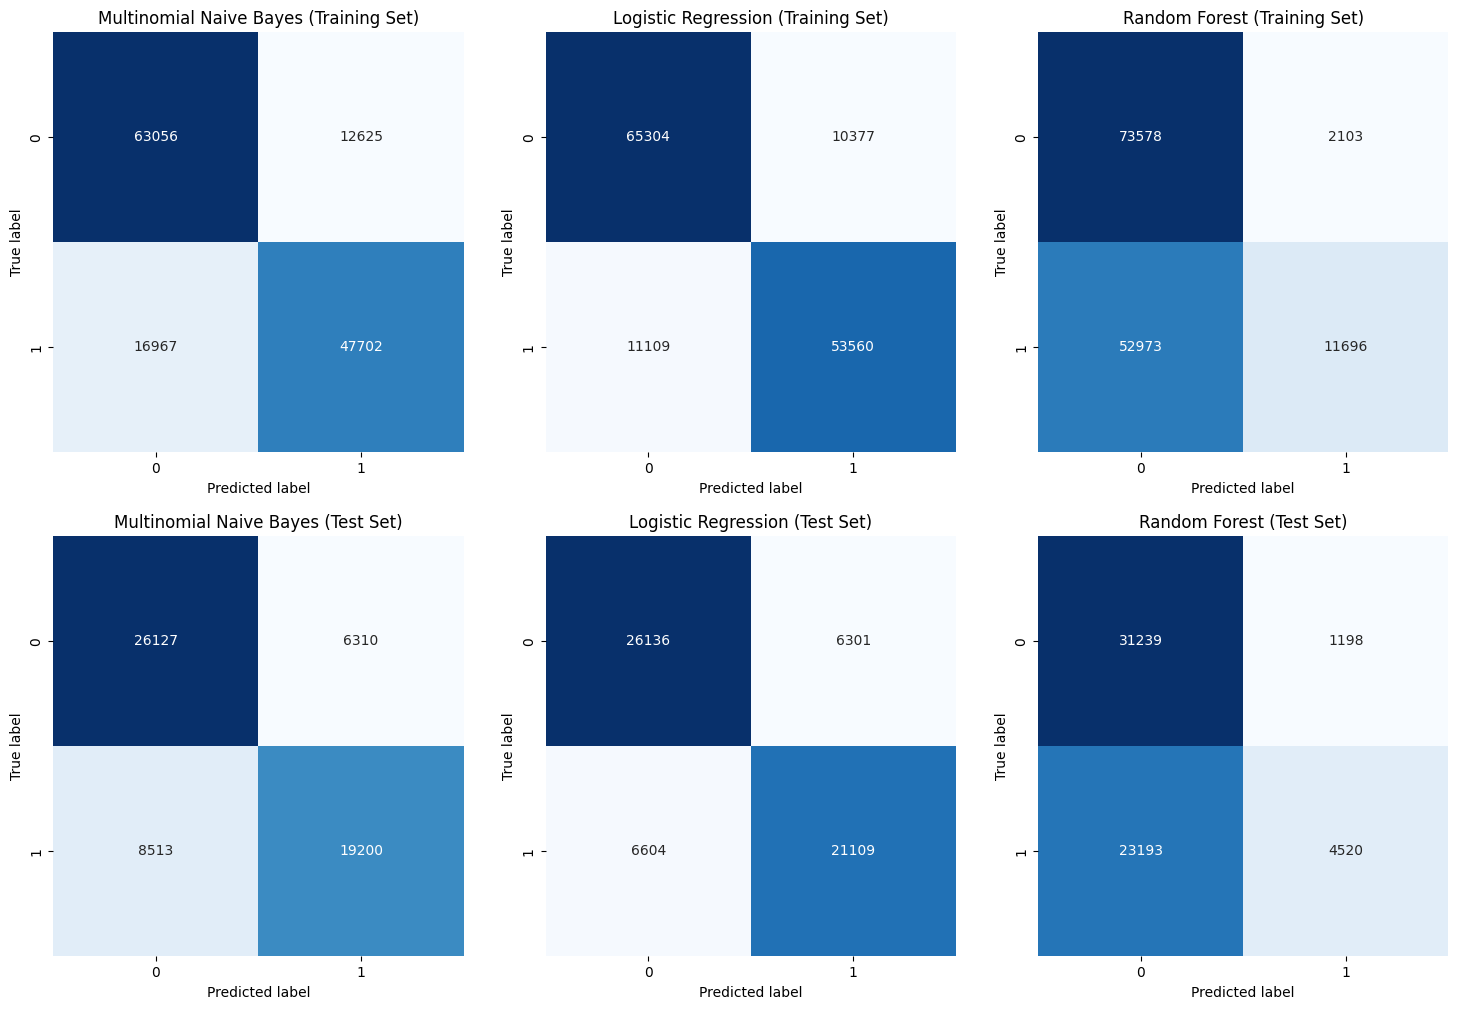

In [25]:
#Plot confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

sns.heatmap(nb_train_conf_mat, annot=True, cmap='Blues', fmt='g', ax=axes[0, 0], cbar=False)
sns.heatmap(lr_train_conf_mat, annot=True, cmap='Blues', fmt='g', ax=axes[0, 1], cbar=False)
sns.heatmap(rf_train_conf_mat, annot=True, cmap='Blues', fmt='g', ax=axes[0, 2], cbar=False)
sns.heatmap(nb_conf_mat, annot=True, cmap='Blues', fmt='g', ax=axes[1, 0], cbar=False)
sns.heatmap(lr_conf_mat, annot=True, cmap='Blues', fmt='g', ax=axes[1, 1], cbar=False)
sns.heatmap(rf_conf_mat, annot=True, cmap='Blues', fmt='g', ax=axes[1, 2], cbar=False)

axes[0, 0].set_title('Multinomial Naive Bayes (Training Set)')
axes[0, 1].set_title('Logistic Regression (Training Set)')
axes[0, 2].set_title('Random Forest (Training Set)')
axes[1, 0].set_title('Multinomial Naive Bayes (Test Set)')
axes[1, 1].set_title('Logistic Regression (Test Set)')
axes[1, 2].set_title('Random Forest (Test Set)')

for ax in axes.flat:
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

plt.show()